In [92]:
import pandas as pd
import boto3
# import S3FS
import os.path
from pathlib import Path
from pyspark.sql import SparkSession
from boto3.session import Session
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from matplotlib.pyplot import figure
from helper_func import *
pd.set_option('display.max_rows', None)

In [93]:
data = pd.read_csv("emscad_v1.csv")

In [94]:
data.drop("in_balanced_dataset", inplace = True, axis = 1)

In [95]:
data["fraudulent"] = data["fraudulent"].replace(["f" , "t"], ["Not Fraud", "Fraud"])

In [96]:
fraud_prop = data.groupby("fraudulent").size().reset_index(name = "counts")
x = np.array(fraud_prop.iloc[:,0])
y = np.array(fraud_prop.iloc[:,1])
total = y.sum()

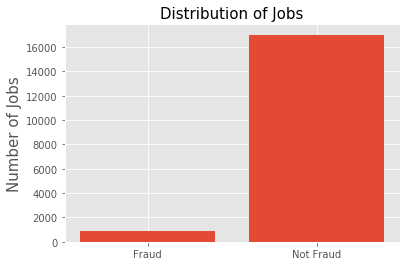

In [97]:
fig = plt.figure()
plt.bar(x, y) 
plt.ylabel("Number of Jobs", fontsize=15) 
plt.title("Distribution of Jobs", fontsize=15)
fig.savefig('images/fraud.png', bbox_inches='tight');

<Figure size 432x288 with 0 Axes>

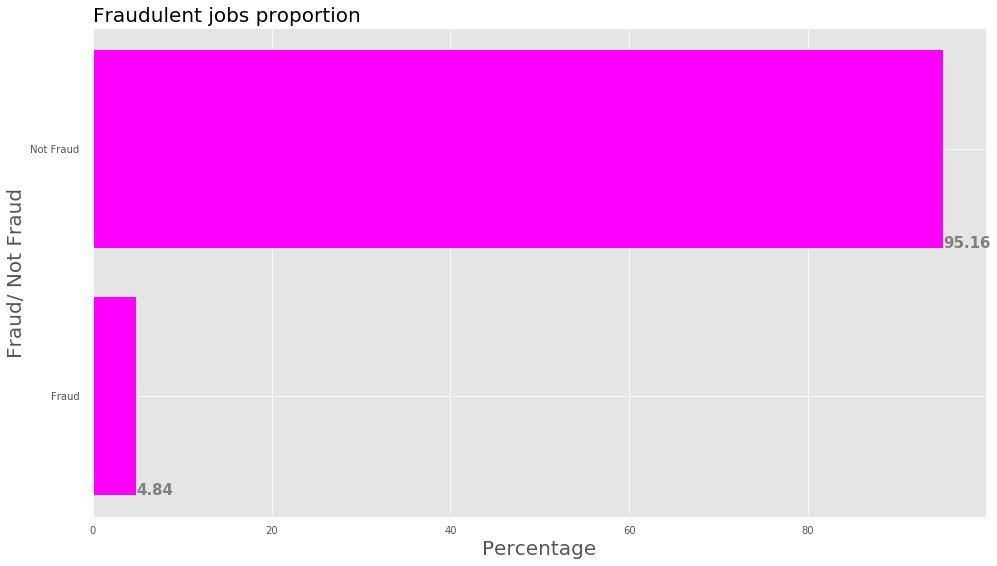

In [7]:
# fraud distribution percentages
fig = plt.figure()
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(x, y*100/total, color="magenta")
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10)
for i in ax.patches: 
    plt.text(i.get_width(), i.get_y(),  
             str(round((i.get_width()), 2)), 
             fontsize = 15, fontweight ='bold', 
             color ='grey')
    
ax.set_title("Fraudulent jobs proportion", 
             loc ='left', fontsize =20) 
ax.set_ylabel("Fraud/ Not Fraud", fontsize =20)
ax.set_xlabel("Percentage", fontsize =20)
fig.savefig('images/fraud_perc.png', bbox_inches='tight')

In [8]:
data["fraudulent"] = data["fraudulent"].replace(["Not Fraud", "Fraud"], [0,1])

binary_cols = ["telecommuting", "has_company_logo","has_questions"]

for col in binary_cols:
    binarize(data,col)



In [9]:
fill_nulls(data)

<Figure size 432x288 with 0 Axes>

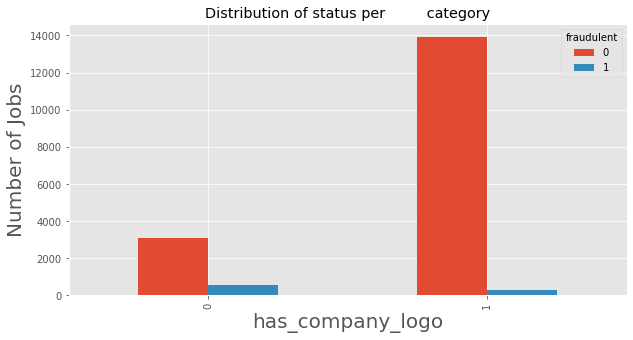

<Figure size 432x288 with 0 Axes>

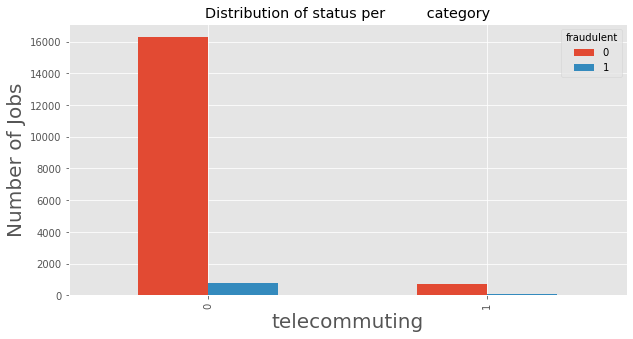

<Figure size 432x288 with 0 Axes>

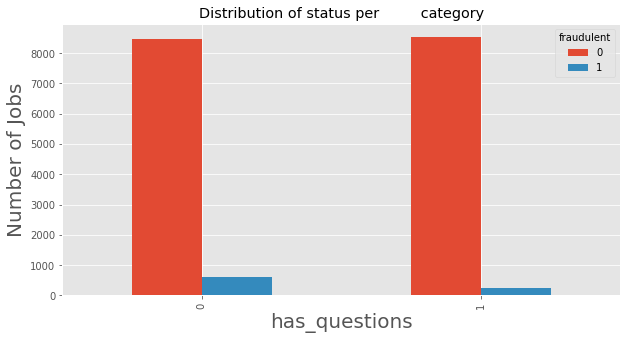

<Figure size 432x288 with 0 Axes>

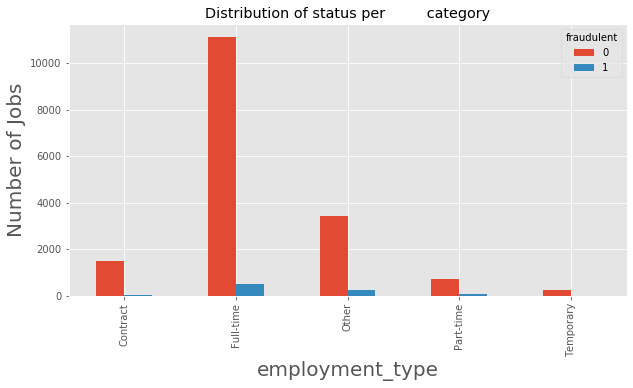

In [10]:
cols = ["has_company_logo","telecommuting", "has_questions", "employment_type" ]

for col in cols:
    plot_bar(data,col)

In [11]:
text_cols = ["title", "company_profile", "description", "requirements", "benefits"]

for col in text_cols:
    clean_cols(data,col)


In [12]:
data.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,market intern,"US, NY, New York",Marketing,Not Specified,were food52 weve creat groundbreak awardwin co...,food52 fastgrow jame beard awardwin onlin food...,experi content manag system major plus ani blo...,,0,1,0,Other,Internship,Unspecified,Not Specified,Marketing,0
1,custom servic cloud video product,"NZ, , Auckland",Success,Not Specified,90 second world cloud video product servic 90 ...,organis focus vibrant awesom passion custom se...,expect you key respons communic client 90 seco...,get u part 90 second team gain experi work pro...,0,1,0,Full-time,Not Applicable,Unspecified,Marketing and Advertising,Customer Service,0
2,commiss machineri assist cma,"US, IA, Wever",Not Specified,Not Specified,valor servic provid workforc solut meet need c...,client locat houston activ seek experienc comm...,implement precommiss commiss procedur rotari e...,,0,1,0,Other,NotSpecified,Unspecified,Not Specified,Other,0
3,account execut washington dc,"US, DC, Washington",Sales,Not Specified,passion improv qualiti life geographi heart ev...,compani esri environment system research insti...,educ bachelor master gi busi administr relat f...,cultur anyth corporatew collabor creativ envir...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,bill review manag,"US, FL, Fort Worth",Not Specified,Not Specified,spotsourc solut llc global human capit manag c...,job titl item review manag locat fort worth tx...,qualif rn licens state texa diploma bachelor s...,full benefit offer,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [17]:
len(data.location.unique())

3106

<Figure size 432x288 with 0 Axes>

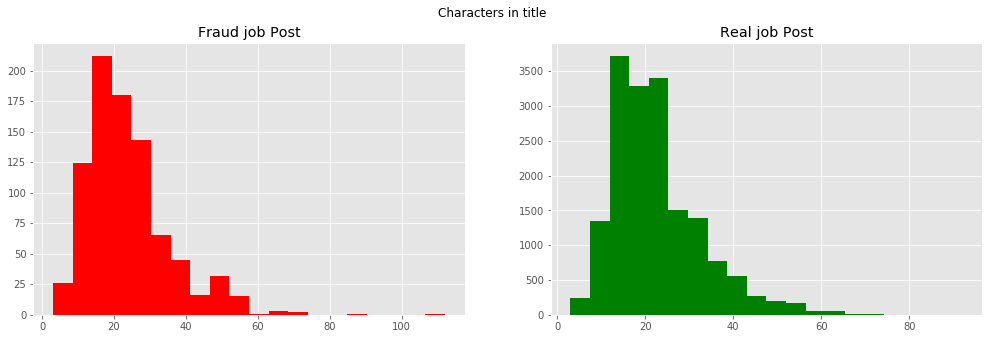

<Figure size 432x288 with 0 Axes>

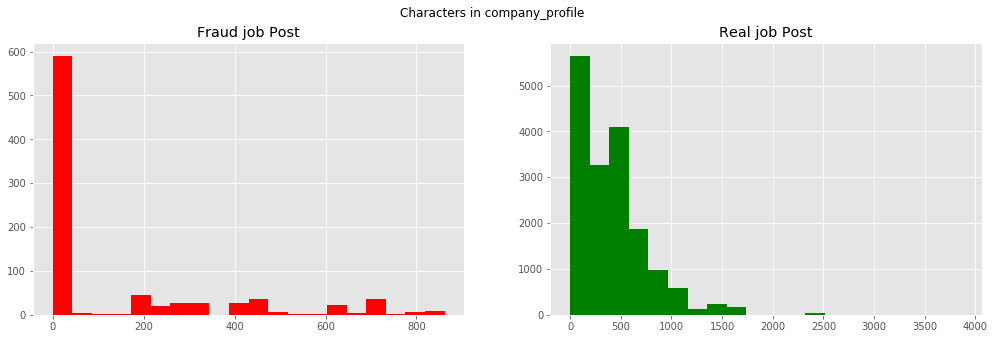

<Figure size 432x288 with 0 Axes>

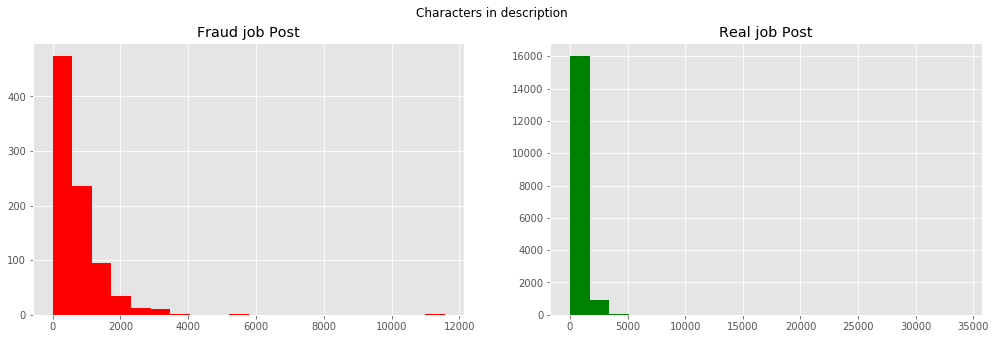

<Figure size 432x288 with 0 Axes>

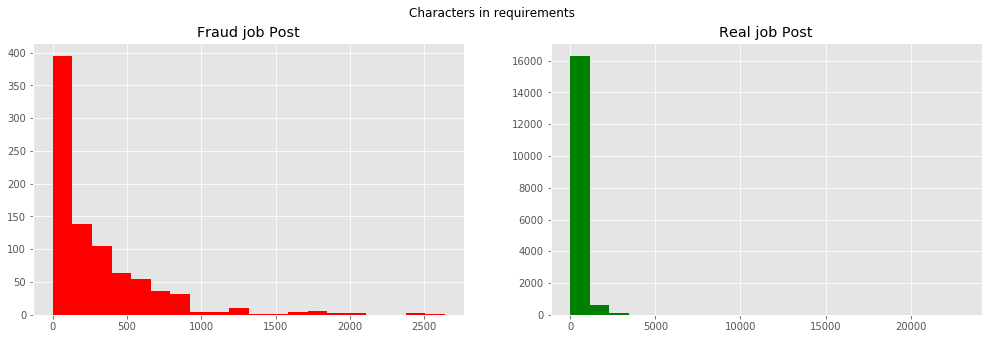

<Figure size 432x288 with 0 Axes>

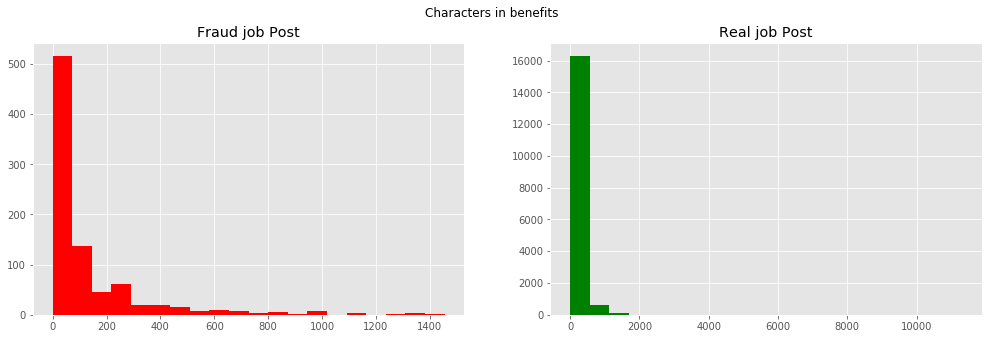

In [13]:
for col in text_cols:
    plot_text(data, col)

<Figure size 432x288 with 0 Axes>

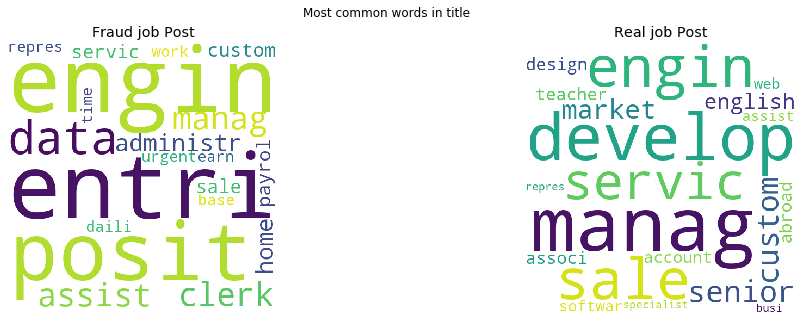

<Figure size 432x288 with 0 Axes>

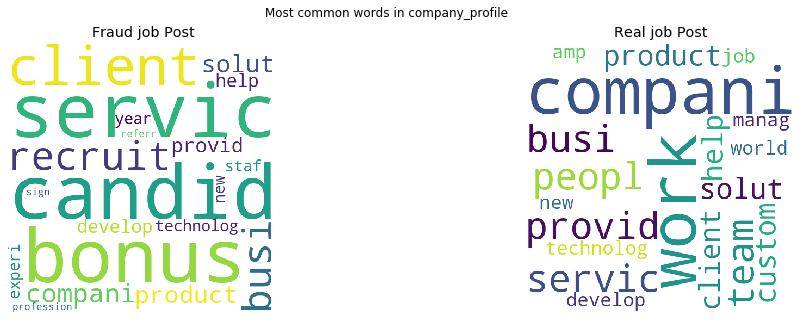

<Figure size 432x288 with 0 Axes>

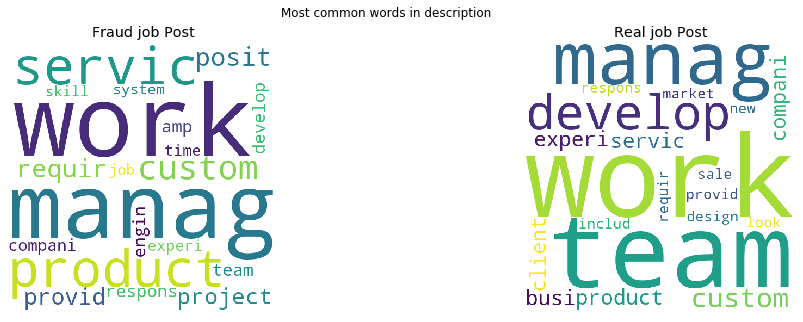

<Figure size 432x288 with 0 Axes>

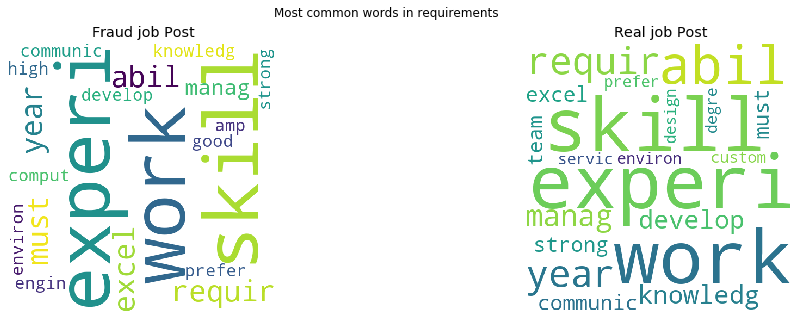

<Figure size 432x288 with 0 Axes>

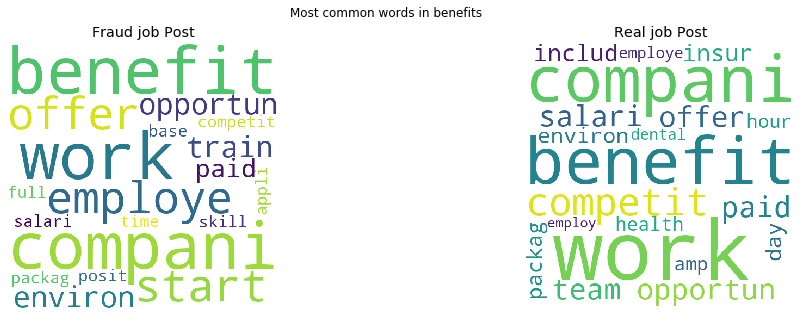

In [14]:
for col in text_cols:
    plot_wordcloud(data, col)

In [15]:
data["text"] = data["title"] + data["company_profile"] + data["description"] + data["requirements"] + data["benefits"]

In [16]:
data.text.head(3)

0    market internwere food52 weve creat groundbrea...
1    custom servic cloud video product90 second wor...
2    commiss machineri assist cmavalor servic provi...
Name: text, dtype: object

## Features Cleaning

In [48]:
df = data.copy()

In [49]:
def clean_features(df):
    df["location"] = df["location"].apply(lambda x: x.split(","))
    df["location"] = df["location"].apply(lambda x: str(x[0])) # Only keeping countries from location column
    df.loc[~df.location.isin(["US", "GB", "GR", "CA", "DE", "Not Specified", "NZ","IN", "AU", "PH", "NL","BE", "IE"]), "location"] = "Other"
    df.loc[df['required_education'].str.contains('Vocational'), 'required_education'] = "Vocational"
    df.loc[df['required_education'].str.contains('High School'), 'required_education'] = "High School"
    df.loc[df['required_education'].str.contains('College'), 'required_education'] = "Bachelor's Degree"
    df.loc[df['industry'].str.contains('Computer'), 'industry'] = "IT"
    df.loc[df['industry'].str.contains('Information'), 'industry'] = "IT"
    df.loc[df['industry'].str.contains('Internet'), 'industry'] = "IT"
    df.loc[df['industry'].str.contains('Insurance'), 'industry'] = "Financial Services"
    df.loc[df['industry'].str.contains('Accounting'), 'industry'] = "Financial Services"
    df.loc[df['industry'].str.contains('Health'), 'industry'] = "Health Care"
    df.loc[df['industry'].str.contains('E-Learning'), 'industry'] = "Education"
    df.loc[df['industry'].str.contains('Education'), 'industry'] = "Education"
    df.loc[df['industry'].str.contains('Recruiting'), 'industry'] = "HR"
    df.loc[df['industry'].str.contains('Human Resources'), 'industry'] = "HR"
    

In [50]:
clean_features(df)

In [53]:
# value_counts less than 100 set to "Others" industry

counts = df["industry"].value_counts()
idx = counts[counts.lt(100)].index

df.loc[df["industry"].isin(idx), "industry"] = 'Others'


## BASELINE MODEL

In [ ]:
# Accuracy is useless in problems with unequal classes and has absolutely no predictive power

In [56]:
df["fraudulent"].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

In [58]:
y_actual = np.array(df["fraudulent"])

In [63]:
y_pred = np.zeros(len(y_actual))

In [87]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
cf = confusion_matrix(y_actual, y_pred)


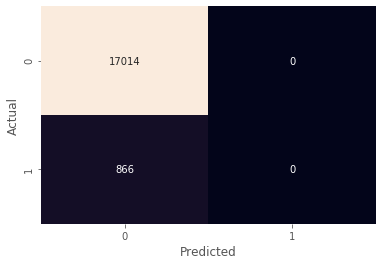

In [91]:
import seaborn as sns
fig = plt.figure()
ax = sns.heatmap(cf, annot=True, cbar=False, fmt='g')
ax.set(xlabel='Predicted', ylabel='Actual')
fig.savefig("images/conf_matrix", bbox_inches='tight')
plt.show()

### Baseline Results

In [90]:
generate_model_report(y_actual, y_pred)

Accuracy: 0.952
Precision: 0.000
Recall: 0.000
F1 score: 0.000
